In [1]:
%matplotlib inline

# Identify a dynamical system for the Wagner function

## Data generation

As a first step we generate data for the analytical form of the Wagner function. As seen in <span style="color: red;">section</span> this can be done by integrating the Theodorsen function in two different ways, depending on the time step we want to compute:
$$
\begin{eqnarray}
  \phi(t) &=& \frac{1}{2} + \frac{2}{\pi}\int_0^\infty \frac{1}{k}\left(G_1(k) - \frac{1}{2}\right)\sin(kt)dk \\
  &=& 1 + \frac{2}{\pi}\int_0^\infty \frac{1}{k}G_2(k)\cos(kt)dk\label{eqn:int_large_t} 
\end{eqnarray}
$$

Where $G_1$ and $G_2$ are the real and imaginary part of the Thodorsen function. 

In [2]:
import numpy as np
from scipy.special import jv, yn # Bessel functions
from scipy.integrate import quad

def Wagner(t, large_times = False): 
    if large_times == False:
        G= lambda k: (jv(1,k)*(jv(1,k)+yn(0,k))+yn(1,k)*(yn(1,k)-jv(0,k)))/((jv(1,k) + yn(0,k))**2 + (yn(1,k) - jv(0,k))**2)
        phi = 1/2 + 2/np.pi*quad(lambda k: 1/k*(G(k)-1/2)*np.sin(k*t), 0, 100, limit = int(100*t)+50)[0]
    else:    
        G= lambda k: (yn(1,k)*yn(0,k)+jv(1,k)*jv(0,k))/((jv(1,k) + yn(0,k))**2 + (yn(1,k) - jv(0,k))**2)
        phi = 1 - 2/np.pi*quad(lambda k: 1/k*G(k)*np.cos(k*t), 0, 100, limit = int(100*t))[0]
    return phi

Since the data genearation is very time consuming, it has been carried out once and the results exported to a `.dat` file. Since sometimes the numerical integration procedure produces cosiderable errors a small function has been made in order to clean, even if only roughly, the imported data before proceeding with the SINDy identification.

The function is based on the assumption that for large times the Wagner functions, or better $1-\phi(t)$, behaves like $t^{-2}$. This allows a normalisation that increases the magnitude of the errors and makes them very easy to identify and correct. The correction is made by doing a mean with the nearest uncorrupted data points.

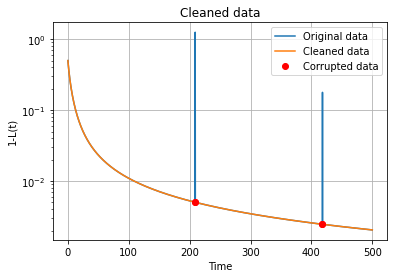

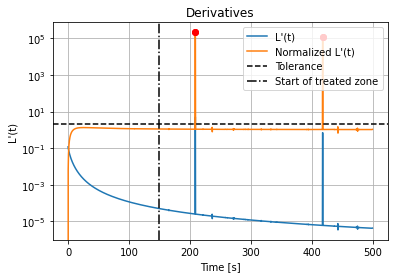

In [3]:
import matplotlib.pyplot as plt

def clean_data(data, tol = 2):
    '''
    The functions cleans numerical errors in the integration, based on the hypothesis that
    these appear in the last phases of the transient phase, for t>>1, and that in this zone 
    the derivative is almost zero.

    INPUT:
    data: n x 2 np.array;
        The data to be cleaned, first column being time and the second L(t)
    tol: float;
        Tolerance on the value of the derivative.

    OUTPUT:
    data: n x 2 np.array;
            Cleaned data.
    '''
    fig_data, ax_data = plt.subplots()
    ax_data.plot(data[:,0],1 - data[:,1])
    
    dt = data[1,0] - data[0,0] # fixed timestep
    derivative = (data[1:,1] - data[0:-1,1]) / dt # backward difference
    der_normalised = derivative * data[0:-1,0]**2
    

    # Find end of first rising time
    rising_tol = 5e-5
    end_rise = 0
    while np.abs(derivative[end_rise]) > rising_tol: # whith normalised data the value ramps up to one
        end_rise += 1
    
    outlier_index = np.where(np.abs(der_normalised) > tol)[0]
    outlier_index = outlier_index[np.where(outlier_index > end_rise)]

    # find nearest non-corrupted data
    # Since numerical errors can come in adiacent points, it is important to find the 
    # nearest uncorrupted data
    if len(outlier_index) != 0:
        diff = outlier_index[1:] - outlier_index[0:-1]
        # print(diff)
        def count_ones(diff):
            count = 1
            counts = []
            for i in range(len(diff)):
                if diff[i] == 1:
                    count += 1
                else:
                    counts.append(count)
                    count = 1
            counts.append(count)
            return counts
        count = count_ones(diff)
        
        non_corrupted_index = np.zeros((len(count),2), dtype=np.int64)
        non_corrupted_index[0,0] = outlier_index[0]-1
        j = 0
        for i in range(len(diff)):
            if diff[i] != 1:
                non_corrupted_index[j,1] = outlier_index[i]+1
                j += 1
                non_corrupted_index[j,0] = outlier_index[i+1]-1
        non_corrupted_index[j,1] = outlier_index[-1]+1
        
        # compute the mean with nearest clean data
    
        mean_index = []
        for i in range(len(count)):
            for j in range(count[i]):
                mean_index.append(non_corrupted_index[i,:])
        
        for i in range(len(outlier_index)):
            outlier = outlier_index[i]
            indices = mean_index[i]
            lower_index = indices[0]
            upper_index = indices[1]
            data[outlier, 1] = (data[lower_index, 1] + data[upper_index, 1]) / 2
   
    # The plotting helps with evaluating the performance of the function
    fig, ax = plt.subplots()
    ax.plot(data[0:-1, 0], np.abs(derivative))
    ax.plot(data[0:-1, 0], np.abs(der_normalised))
    ax.axhline(y = tol,color =  'k', linestyle = '--')
    ax.axvline(data[end_rise,0], color = 'k', linestyle = '-.')
    ax.plot(data[outlier_index,0],np.abs(der_normalised[outlier_index]), color = 'r', marker = 'o', linestyle = 'None')
    ax.set_title('Derivatives')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('L\'(t)')
    ax.set_yscale('log')
    ax.legend(['L\'(t)', 'Normalized L\'(t)', 'Tolerance', 'Start of treated zone'])
    ax.grid(True)
    
    ax_data.plot(data[:,0],1 - data[:,1])
    ax_data.plot(data[outlier_index,0], 1 - data[outlier_index,1], color = 'r', marker = 'o', linestyle = 'None')
    ax_data.set_xlabel('Time')
    ax_data.set_ylabel('1-L(t)')
    ax_data.set_title('Cleaned data')
    ax_data.set_yscale('log')
    ax_data.grid(True)
    ax_data.legend(['Original data', 'Cleaned data', 'Corrupted data'])

    plt.show()
    return data

wagner_data = np.loadtxt('wagner_data.dat', dtype=float)
cleaned_wagner_data = clean_data(wagner_data)

t = cleaned_wagner_data[:,0] 
x = 1 - cleaned_wagner_data[:,1] # normalized, steady-state-subtracted lift (see reference [1])
x = np.array([x]).T

The fact that generating a clean dataset is so time consuming is a statement to the need of a precise but easily computed model for the Wagner function. As stated in {cite}`dawson2022improved`, this can be done by fitting a simple nonlinear ODE in the polynomial form:
$$
\dot L(t) = \sum_{i=0}^r\xi_iL^i(t)
$$

where $\xi_r$ is the coefficient of the term of order $r$. Once this type of model is correctly identified it can be simulated forward in time as much as needed, or used as part of a closed or open loop controller. In order to do so we have tried to replicate the results proposed in {cite}`dawson2022improved` for $r = 1,\dots,8$ 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pysindy/optimizers/stlsq.py:183: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


(phi)' = -0.525 phi^2
(phi)' = -0.680 phi^2 + 0.396 phi^3


(phi)' = -0.868 phi^2 + 1.575 phi^3 + -1.684 phi^4


(phi)' = -0.981 phi^2 + 2.844 phi^3 + -5.902 phi^4 + 4.306 phi^5


(phi)' = -1.006 phi^2 + 3.280 phi^3 + -8.389 phi^4 + 10.019 phi^5 + -4.581 phi^6


(phi)' = -1.059 phi^2 + 4.598 phi^3 + -19.680 phi^4 + 53.369 phi^5 + -81.240 phi^6 + 50.870 phi^7


(phi)' = -1.049 phi^2 + 4.226 phi^3 + -15.028 phi^4 + 26.150 phi^5 + -68.977 phi^7 + 69.306 phi^8


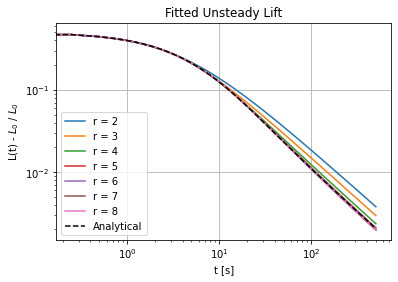

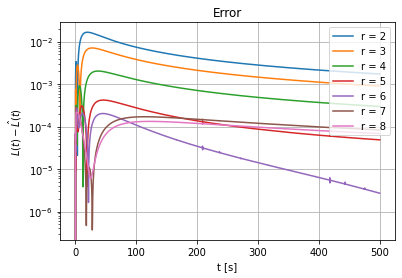

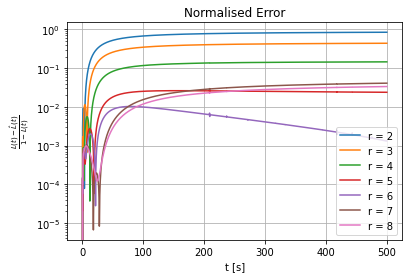

In [4]:
import pysindy as ps

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

for deg in range(0,9):
    	# fitting model
        optimizer = ps.optimizers.stlsq.STLSQ(threshold = 0.1, alpha = 1e-06, max_iter = 10)
        library = ps.feature_library.polynomial_library.PolynomialLibrary(degree = deg)
        model = ps.SINDy(optimizer = optimizer, 
       				     feature_library = library,
       				     feature_names = ['phi']) # default paramaters:
       					   						  # differentiation method: centered differences
        
        model.fit(x, t = t[1] - t[0]) # fitting the model        
       
        x0 = np.array([0.5])
        model_x = model.simulate(x0, t) # evaluating forward in time to compare
        
        err_norm = np.abs(x - model_x) / x # noramlised error
        err = np.abs(x - model_x) # error
        
    	# plotting
        if deg > 1:
            model.print()

            ax1.plot(t, model_x)
            ax1.set_xlabel('t [s]')
            ax1.set_ylabel(r'L(t) - $L_0$ / $L_0$')
            ax1.set_title('Fitted Unsteady Lift')
            ax1.set_xscale('log')
            ax1.set_yscale('log')
            ax1.grid(True)
           
            ax2.plot(t, err)
            ax2.set_xlabel('t [s]')
            ax2.set_ylabel(r'$L(t) - \hat{L}(t)$')
            ax2.set_yscale('log')
            ax2.set_title('Error')
            ax2.grid(True)
            
            ax3.plot(t, err_norm)
            ax3.set_xlabel('t [s]')
            ax3.set_ylabel(r'$\frac{L(t) - \hat{L}(t)}{1 - L(t)}$')
            ax3.set_yscale('log')
            ax3.set_title('Normalised Error')
            ax3.grid(True)

    
ax1.plot(t, x, 'k--')

ax1.legend(['r = 2','r = 3','r = 4','r = 5','r = 6','r = 7','r = 8', 'Analytical'])
ax2.legend(['r = 2','r = 3','r = 4','r = 5','r = 6','r = 7','r = 8'], loc = 'upper right')
ax3.legend(['r = 2','r = 3','r = 4','r = 5','r = 6','r = 7','r = 8'], loc = 'lower right')

plt.show()

As in {cite}`dawson2022improved` $\xi_0$ and $\xi_1$ are always zero. The results for $r=7$ and $r=8$ are quite far from of the others, and in fact perform worse than the $r=6$ case. Possible explanations for this include:
*  The residual errors not corrected by the correction algorithm
*  An attempt of the algorithm to minimise the error at the beginning, with repercussions of the accuracy for greater times
*  A not long enough time window

The results, even though somewhat different from those presented in {cite}`dawson2022improved`, are nonetheless satisfying. In particular for $r=6$ the relative error goes down as much as $10^{-3}$, which is remarkable.

The results show that the SINDy algorithm, even if quite robust, necessitates of very clean and complete data to work properly, especially in terms of repeatability of the results.

We can try to fit the data using orthogonal polynomials. To do so it is sufficient to generate the data library using the dedicated script and pass it to the algorithm. 

(phi)' = -0.002 f0() + -0.165 f1(phi) + -0.436 f2(phi)


(phi)' = -0.002 f0() + -0.165 f1(phi) + -0.436 f2(phi) + 0.143 f3(phi)


(phi)' = -0.002 f0() + -0.165 f1(phi) + -0.436 f2(phi) + 0.143 f3(phi) + -1.187 f4(phi)


(phi)' = -0.002 f0() + -0.158 f1(phi) + -0.436 f2(phi) + 0.143 f3(phi) + -1.187 f4(phi) + 3.639 f5(phi)


(phi)' = -0.002 f0() + -0.158 f1(phi) + -0.436 f2(phi) + 0.143 f3(phi) + -1.187 f4(phi) + 3.639 f5(phi) + -1.746 f6(phi)


(phi)' = -0.003 f0() + -0.204 f1(phi) + -0.598 f2(phi) + 0.143 f3(phi) + -1.187 f4(phi) + 3.639 f5(phi) + -1.746 f6(phi) + 64.473 f7(phi)


(phi)' = -0.002 f0() + -0.176 f1(phi) + -0.501 f2(phi) + 0.143 f3(phi) + -1.187 f4(phi) + 3.639 f5(phi) + -1.746 f6(phi) + 64.473 f7(phi) + 197.176 f8(phi)


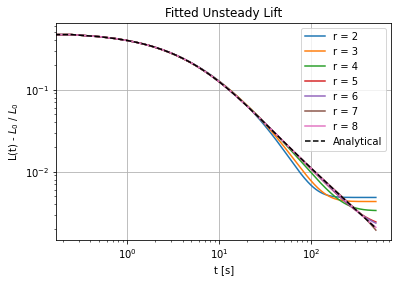

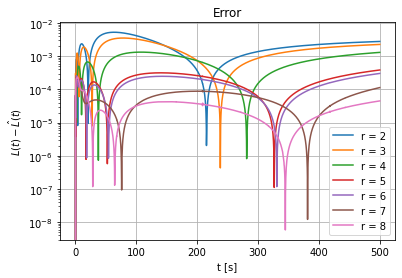

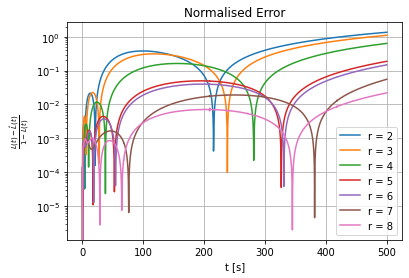

In [5]:
from PolynomialChaos import *

aPC_Wagner = PolynomialChaos(
    x,
    expansionDegree = 8,
    numberOfInputs = 1)
aPC_Wagner.ComputeCoefficients(threshold = 1e-2, normalize = False)
coefficients = aPC_Wagner.coefficients
AlphaMatrix = aPC_Wagner.AlphaMatrix

LibraryList = GenerateLibraryList(
    expansionDegree=8,
    coefficients = coefficients,
    AlphaMatrix = AlphaMatrix)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

for deg in range(0,9):
    	# fitting model
        optimizer = ps.optimizers.stlsq.STLSQ(threshold = 0.0, alpha = 1e-06, max_iter = 10)
        library = ps.feature_library.custom_library.CustomLibrary(LibraryList[0:deg+1])
        model = ps.SINDy(optimizer = optimizer, 
       				     feature_library = library,
       				     feature_names = ['phi']) # default paramaters:
       					   						  # differentiation method: centered differences
        
        model.fit(x, t = t[1] - t[0])
        
       
        x0 = np.array([0.5])
        model_x = model.simulate(x0, t)
        
        err_norm = np.abs(x - model_x) / x
        err = np.abs(x - model_x)
        
    	# plotting
        if deg > 1:
            model.print()

            ax1.plot(t, model_x)
            ax1.set_xlabel('t [s]')
            ax1.set_ylabel(r'L(t) - $L_0$ / $L_0$')
            ax1.set_title('Fitted Unsteady Lift')
            ax1.set_xscale('log')
            ax1.set_yscale('log')
            ax1.grid(True)
           
            ax2.plot(t, err)
            ax2.set_xlabel('t [s]')
            ax2.set_ylabel(r'$L(t) - \hat{L}(t)$')
            ax2.set_yscale('log')
            ax2.set_title('Error')
            ax2.grid(True)
            
            ax3.plot(t, err_norm)
            ax3.set_xlabel('t [s]')
            ax3.set_ylabel(r'$\frac{L(t) - \hat{L}(t)}{1 - L(t)}$')
            ax3.set_yscale('log')
            ax3.set_title('Normalised Error')
            ax3.grid(True)
    
ax1.plot(t, x, 'k--')

ax1.legend(['r = 2','r = 3','r = 4','r = 5','r = 6','r = 7','r = 8', 'Analytical'])
ax2.legend(['r = 2','r = 3','r = 4','r = 5','r = 6','r = 7','r = 8'], loc = 'lower right')
ax3.legend(['r = 2','r = 3','r = 4','r = 5','r = 6','r = 7','r = 8'], loc = 'lower right')

plt.show()


We can observe that the results are not particularly better. In particular, if any thresholding is applied when fitting the model the result quality decreases drastically, which prevents us from using the sparsity promoting capability of SINDy to the fullest. This results in the appearence of zeroth and first order terms, even though these are cancelled out when higher order terms appear.

However, as we coulf expect, new terms are added without drastically modifying the previuos ones, which is a statement about the orthogonalisation procedure.

Here below we report the form of the orthogonal polynomials for this dataset.

In [6]:
aPC_Wagner.printFeatureNames()

f0: 1
f1: (-0.014 + 1.000x0)
f2: (-0.306x0 + 1.000x0^2)
f3: (0.063x0 + -0.567x0^2 + 1.000x0^3)
f4: (-0.011x0 + 0.192x0^2 + -0.825x0^3 + 1.000x0^4)
f5: (-0.051x0^2 + 0.387x0^3 + -1.081x0^4 + 1.000x0^5)
f6: (0.012x0^2 + -0.137x0^3 + 0.646x0^4 + -1.335x0^5 + 1.000x0^6)
f7: (0.040x0^3 + -0.282x0^4 + 0.966x0^5 + -1.587x0^6 + 1.000x0^7)
f8: (-0.010x0^3 + 0.100x0^4 + -0.501x0^5 + 1.345x0^6 + -1.835x0^7 + 1.000x0^8)
